# Diversity and Ability
This notebook contains code to analyse the simulation data. 

## Setup

In [63]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import os

## Initial exploration

In [64]:
file = "simulation_20241127_150825"
df = pd.read_csv(f"data/{file}.csv")
df_div = df[df["team_type"] == "diverse"]
df_exp = df[df["team_type"] == "expert"]
df.head()

,Unnamed: 0.1,Unnamed: 0,team_size,n_sources,heuristic_size,reliability_mean,n_samples,team_type,accuracy,diversity,average
0,0,0,9,17,5,0.6,10000,expert,0.818156,0.277778,0.793782
1,1,1,9,17,5,0.6,10000,diverse,0.780815,0.783333,0.680203
2,2,2,9,17,5,0.6,10000,diverse,0.785010,0.783333,0.682912
3,3,3,9,17,5,0.6,10000,diverse,0.785470,0.783333,0.684248
4,4,4,9,17,5,0.6,10000,diverse,0.778586,0.783333,0.679545


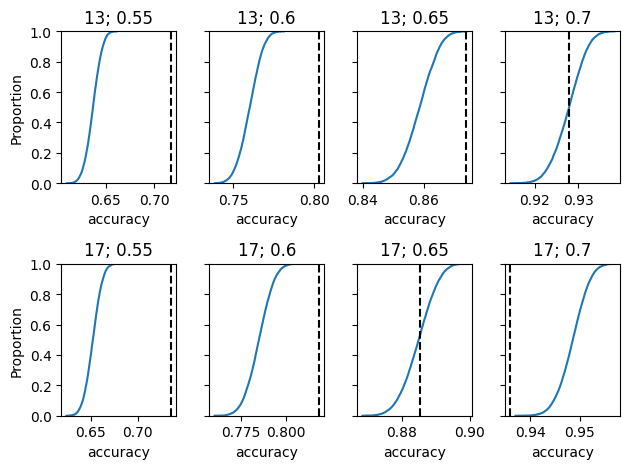

In [ ]:
fig, ax = plt.subplots(nrows=2, ncols=4, sharey=True)
date = "20241127"
files = [file for file in os.listdir("data") if file[:10] == "simulation" and date in file and not "README" in file]
for counter, file in enumerate(files):
    if counter < 4:
        ax_loc = ax[0, counter]
    else:
        ax_loc = ax[1, (counter - 4)]
    df = pd.read_csv(f"data/{file}")
    df_div = df[df["team_type"] == "diverse"]
    df_exp = df[df["team_type"] == "expert"]
    x_expert = df_exp.at[0,"accuracy"]
    rel_mean = df_exp.at[0, "reliability_mean"]
    n_sources = df_exp.at[0, "n_sources"]
    # sns.histplot(data=df_div, x="accuracy", bins=50, stat="percent", ax=ax_loc)
    sns.ecdfplot(data=df_div, x="accuracy", ax=ax_loc)
    ax_loc.axvline(x=x_expert, color="k", linestyle="--")
    ax_loc.set_title(f"{n_sources}; {rel_mean}")
fig.tight_layout()

In [75]:
len(df_div.index)

10000

In [116]:
from scipy import stats

def perform_wilcoxon(file, x="accuracy"):
    if file[-4:] != ".csv":
        file = f"{file}.csv"
    df = pd.read_csv(f"data/{file}") # "data/simulation_20241127_160327.csv") # ("data/simulation_20241127_140856.csv") 
    df_exp = df[df["team_type"] == "expert"]
    df_div = df[df["team_type"] == "diverse"]
    df_test = df_div.copy()
    x_expert = df_exp.at[0, x]
    df_test[f"{x}_expert"] = x_expert
    result = stats.wilcoxon(df_test["accuracy"], df_test[f"{x}_expert"])
    p_value = result.pvalue
    statistic = result.statistic
    div_mean = df_div["accuracy"].mean()
    result_dict = {
        "p_value": p_value,
        "statistic": statistic,
        "effect": x_expert - div_mean,
    }
    return result_dict

print("13, 0.7:")
print( perform_wilcoxon("simulation_20241127_140856"))

print("17, 0.65:")
print(perform_wilcoxon("simulation_20241127_160327"))


13, 0.7:
{'p_value': 0.9766386308551501, 'statistic': 24994046.0, 'effect': 5.328194029907696e-05}
17, 0.65:
{'p_value': 6.63535327261991e-27, 'statistic': 21902021.0, 'effect': 0.0005987755130418826}


In [117]:
def produce_stats_wilcoxon():
    date = "20241127"
    files = [file for file in os.listdir("data") if file[:10] == "simulation" and date in file and not "README" in file]
    results = []
    for file in files:
        df = pd.read_csv(f"data/{file}")
        n_sources = df.at[0, "n_sources"]
        rel_mean = df.at[0, "reliability_mean"]
        result = perform_wilcoxon(file, x="accuracy")
        results.append([
            n_sources, rel_mean, round(result["p_value"], 4), round(result["statistic"]), round(result["effect"], 3),
        ])
    columns = ["n_sources", "rel_mean", "p_value", "statistic", "effect"]
    return pd.DataFrame(results, columns=columns)
        
produce_stats_wilcoxon()
        

,n_sources,rel_mean,p_value,statistic,effect
0,13,0.55,0.0000,0,0.081
1,13,0.60,0.0000,0,0.043
2,13,0.65,0.0000,6,0.015
3,13,0.70,0.9766,24994046,0.000
4,17,0.55,0.0000,0,0.083
5,17,0.60,0.0000,0,0.033
6,17,0.65,0.0000,21902021,0.001
7,17,0.70,0.0000,0,-0.013


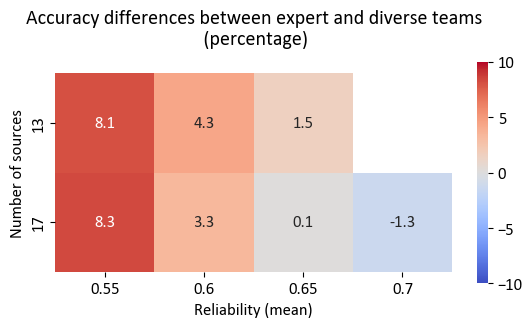

In [130]:
def visualize_heatmap(
    mask: bool = False,
):
    df = produce_stats_wilcoxon()
    df["effect_percent"] = 100 * df["effect"]
    pivot_df = df.pivot(
        index="n_sources", 
        columns="rel_mean", 
        values="effect_percent",
    )
    
    
    mask_df = df.pivot(
        index="n_sources", 
        columns="rel_mean", 
        values="p_value",
    )
    mask_df = mask_df.astype(bool)
    
    font_style = {"family": "Calibri", "size": 12}
    plt.rc("font", **font_style)
    
    if mask:
        fig = sns.heatmap(pivot_df, annot=True, vmin=-10, vmax=10, cmap="coolwarm", square=True, mask=mask_df, cbar_kws={"shrink": 0.6})
    else: 
        fig = sns.heatmap(pivot_df, annot=True, vmin=-10, vmax=10, cmap="coolwarm", square=True, cbar_kws={"shrink": 0.6})
    
    fig.set_xlabel("Reliability (mean)")
    fig.set_ylabel("Number of sources")
    fig.set_title("Accuracy differences between expert and diverse teams\n (percentage)\n")
    plt.savefig(f"figures/heatmap_new")

visualize_heatmap(mask=True)